# Training of letter patterns for CLEMSite

## Using Convolutional Neural Networks 

---

In this notebook, we train a CNN to recognise characters from a Mattek grid. First, from original images we crop the essential characters forming the grid matrix. This is done manually from original light microscopy images coming from reflected light. It is a total of 36 letters, '0-9' and 'A-Z'. Using a script (generateSynthetic part 1), we create a total of 546 characters, corresponding to the available combinations of letters given by the manufacturer, i.e. combinations from 0-9 A-K with A-Z,   $21*26 = 546$. Resultant synthetic patterns are stored in Fnt1.

The resultant synthetic dataset is augmented using a combination of noise (salt and pepper, gaussian, poisson, ruptures, added particles, small angle perturbations) and a sequence of dilations to simulate letters from real datasets. We generate 20 letters of each combination and we store them in Fnt3.  

Additionally we gathered a total of 1115 letters cropped from real data. Another script extracts them from folders and places them in Fnt2. We transfer the data from Fnt2 to Fnt3 combining both datasets, synthetic plus real data to generate our training, validation and test datasets.

### 1. Load dataset and split for training,validation and test.


In [1]:
import keras
import numpy as np
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split

def load_dataset(path):
    data = load_files(path)
    letter_files = np.array(data['filenames'])
    letter_targets = np_utils.to_categorical(np.array(data['target']), 546)
    return letter_files, letter_targets


letter_files, letter_targets = load_dataset('.\\Fnt3')
# Split in train, valid and targets
x_train, x_test, y_train, y_test = train_test_split(letter_files, letter_targets, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

Using TensorFlow backend.


7702 train samples
2407 test samples
1926 validation samples


### 2. Visualize the First 36 Training Images

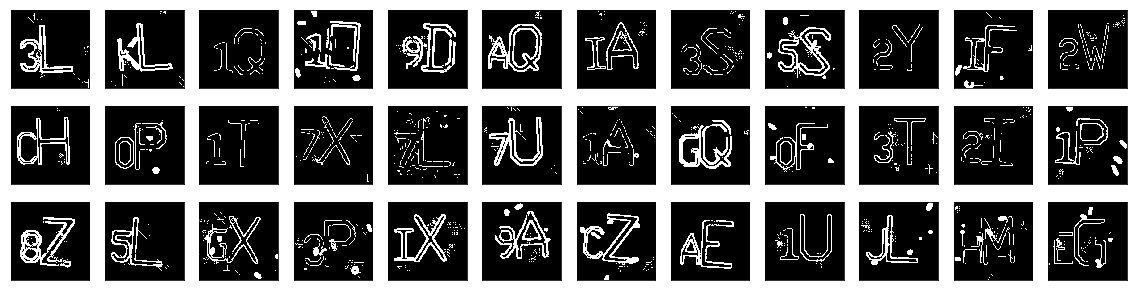

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    img = cv2.imread(x_train[i])
    ax.imshow(np.squeeze(img))

### 3. Load images and resize to 128,128
128 by 128 was found optimal to get the best trade off between number of network parameters and training data size. As a requirement from tensorflow, images have to be expanded to tensors and converted to floats.

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm
from skimage import data, io, filters

def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    final = cv2.resize(img,(128,128))
    final = np.array(final,dtype=np.float32)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 1) and return 4D tensor
    return np.expand_dims(final, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(x_train)
valid_tensors = paths_to_tensor(x_valid)
test_tensors = paths_to_tensor(x_test)

100%|██████████| 2407/2407 [00:01<00:00, 1408.25it/s]


### 4.  Load images 
Additionally we read the directories to obtain a list with the real name of classes.

In [4]:
train_tensors = np.expand_dims(train_tensors, axis=3)
valid_tensors = np.expand_dims(valid_tensors, axis=3)
test_tensors = np.expand_dims(test_tensors, axis=3)

In [5]:
# Get all data names from directories
from os import listdir
from os.path import isfile, join

adir = ".\\Fnt3"
my_letters = [f for f in listdir(adir) if not isfile(join(adir, f))]
str(my_letters)

"['0A', '0B', '0C', '0D', '0E', '0F', '0G', '0H', '0I', '0J', '0K', '0L', '0M', '0N', '0O', '0P', '0Q', '0R', '0S', '0T', '0U', '0V', '0W', '0X', '0Y', '0Z', '1A', '1B', '1C', '1D', '1E', '1F', '1G', '1H', '1I', '1J', '1K', '1L', '1M', '1N', '1O', '1P', '1Q', '1R', '1S', '1T', '1U', '1V', '1W', '1X', '1Y', '1Z', '2A', '2B', '2C', '2D', '2E', '2F', '2G', '2H', '2I', '2J', '2K', '2L', '2M', '2N', '2O', '2P', '2Q', '2R', '2S', '2T', '2U', '2V', '2W', '2X', '2Y', '2Z', '3A', '3B', '3C', '3D', '3E', '3F', '3G', '3H', '3I', '3J', '3K', '3L', '3M', '3N', '3O', '3P', '3Q', '3R', '3S', '3T', '3U', '3V', '3W', '3X', '3Y', '3Z', '4A', '4B', '4C', '4D', '4E', '4F', '4G', '4H', '4I', '4J', '4K', '4L', '4M', '4N', '4O', '4P', '4Q', '4R', '4S', '4T', '4U', '4V', '4W', '4X', '4Y', '4Z', '5A', '5B', '5C', '5D', '5E', '5F', '5G', '5H', '5I', '5J', '5K', '5L', '5M', '5N', '5O', '5P', '5Q', '5R', '5S', '5T', '5U', '5V', '5W', '5X', '5Y', '5Z', '6A', '6B', '6C', '6D', '6E', '6F', '6G', '6H', '6I', '6J', '6

### 5. Create and Configure Augmented Image Generator
Despite the data is already augmented, a small range of augmentations is also desired to achieve better performance. It is important to give horizontally flipped images, so letters from SEM will be equally recognized later.

In [7]:
# create and configure augmented image generator using keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest')


# fit augmented image generator on data
datagen.fit(train_tensors)

### 6. Visualize Original and Augmented Images

100%|██████████| 12/12 [00:00<00:00, 921.25it/s]


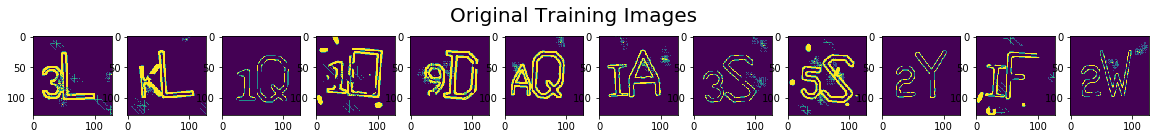

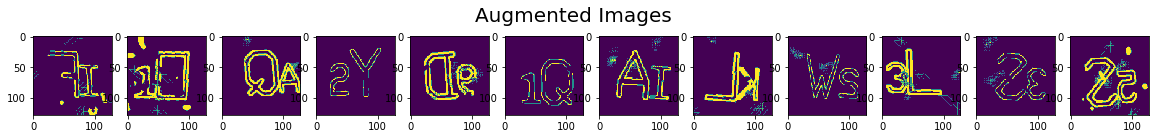

In [8]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = paths_to_tensor(x_train[:12])

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen.flow(train_tensors[:12], batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i,:,:,0])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

This architecture is based on 'Deep Learning Architectures for Hard Character Classification' from Vy Bui and Lin-Ching Chang (ICAI 2016). The architecture we used is similar with additional modifications : we used dropouts starting at 0.1 and increasing at the end to be 0.5 for the fully connected layer, a batch normalization before a max pooling layer and a global average pooling instead of a flatten. Instead of having a fully connected layer of 546, we added a pre intermediated layer with 192 nodes (number equivalent to the number of features to analyze from the CNN, can be changed). The resultant network has a total of 400,000 parameters. 

In [9]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(546, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

### 8. Compile the Model 

In [10]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 9. Train the Model 

In [11]:

from keras.callbacks import ModelCheckpoint   

batch_size = 20
epochs = 70

# train the model
checkpointer = ModelCheckpoint(filepath='letters_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
   

    
hist = model.fit_generator(
        datagen.flow(train_tensors, y_train,batch_size=batch_size),
        steps_per_epoch= y_train.shape[0] // batch_size,
        epochs=epochs,
        verbose =2,
        callbacks = [checkpointer],
        validation_data= datagen.flow(valid_tensors, y_valid,batch_size=batch_size),
        validation_steps= y_valid.shape[0] // batch_size)


Epoch 1/70
Epoch 00000: val_loss improved from inf to 6.23479, saving model to letters_model.weights.best.hdf5
751s - loss: 6.3132 - acc: 0.0038 - val_loss: 6.2348 - val_acc: 0.0016
Epoch 2/70
Epoch 00001: val_loss improved from 6.23479 to 5.80439, saving model to letters_model.weights.best.hdf5
761s - loss: 5.9742 - acc: 0.0079 - val_loss: 5.8044 - val_acc: 0.0058
Epoch 3/70
Epoch 00002: val_loss improved from 5.80439 to 4.94815, saving model to letters_model.weights.best.hdf5
792s - loss: 5.4521 - acc: 0.0181 - val_loss: 4.9482 - val_acc: 0.0341
Epoch 4/70
Epoch 00003: val_loss improved from 4.94815 to 4.29277, saving model to letters_model.weights.best.hdf5
787s - loss: 4.8335 - acc: 0.0435 - val_loss: 4.2928 - val_acc: 0.0714
Epoch 5/70
Epoch 00004: val_loss improved from 4.29277 to 3.61135, saving model to letters_model.weights.best.hdf5
773s - loss: 4.2890 - acc: 0.0775 - val_loss: 3.6113 - val_acc: 0.1275
Epoch 6/70
Epoch 00005: val_loss improved from 3.61135 to 3.03922, saving 

Epoch 53/70
Epoch 00052: val_loss did not improve
734s - loss: 0.2895 - acc: 0.9190 - val_loss: 0.0971 - val_acc: 0.9743
Epoch 54/70
Epoch 00053: val_loss did not improve
732s - loss: 0.2852 - acc: 0.9223 - val_loss: 0.0574 - val_acc: 0.9869
Epoch 55/70
Epoch 00054: val_loss did not improve
734s - loss: 0.2629 - acc: 0.9210 - val_loss: 0.0689 - val_acc: 0.9832
Epoch 56/70
Epoch 00055: val_loss did not improve
740s - loss: 0.2489 - acc: 0.9264 - val_loss: 0.0555 - val_acc: 0.9885
Epoch 57/70
Epoch 00056: val_loss did not improve
752s - loss: 0.2857 - acc: 0.9262 - val_loss: 0.0610 - val_acc: 0.9869
Epoch 58/70
Epoch 00057: val_loss did not improve
751s - loss: 0.2718 - acc: 0.9273 - val_loss: 0.0638 - val_acc: 0.9837
Epoch 59/70
Epoch 00058: val_loss did not improve
752s - loss: 0.2565 - acc: 0.9266 - val_loss: 0.0643 - val_acc: 0.9843
Epoch 60/70
Epoch 00059: val_loss improved from 0.04925 to 0.03787, saving model to letters_model.weights.best.hdf5
747s - loss: 0.2634 - acc: 0.9265 - v

### 10. Load the Model with the Best Validation Accuracy

In [12]:
# load the weights that yielded the best validation accuracy
model.load_weights('letters_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

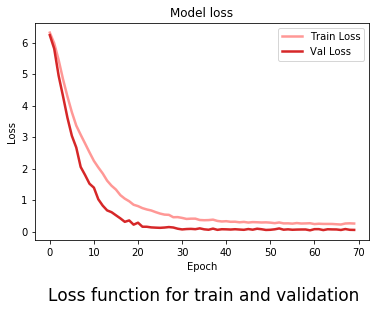

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

colortable = [(255, 152, 150), (214, 39, 40)]  

for i in range(len(colortable)):  
    r, g, b =   colortable[i]
    colortable[i] = (r / 255., g / 255., b / 255.)  
    
plt.plot(hist.epoch, hist.history['loss'], lw=2.5, color = colortable[0])    
plt.plot(hist.epoch, hist.history['val_loss'], lw=2.5, color= colortable[1])  
plt.text(35, -2.2, "Loss function for train and validation", fontsize=17, ha="center")  
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [25]:
# report test accuracy
score = model.evaluate(test_tensors, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1]*100)


 Test accuracy: 98.5043622792


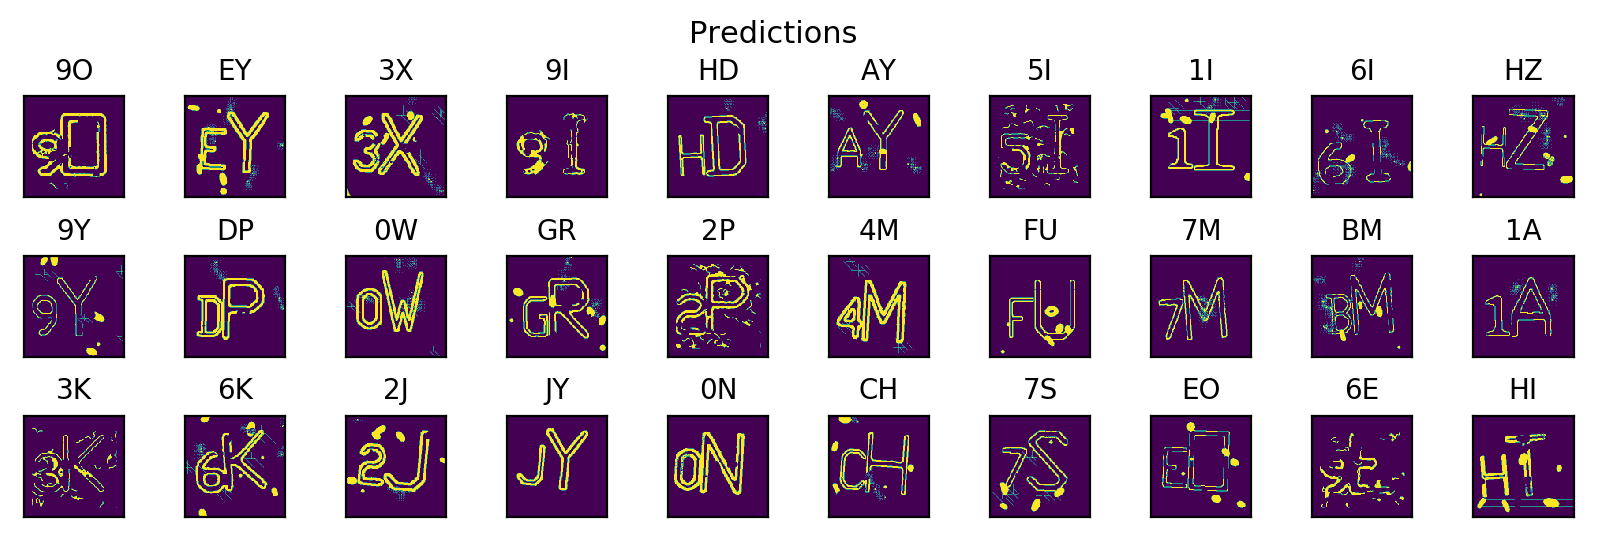

In [152]:
# get index of predicted character for each image in the test set
letter_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
# visualize subset of test data plus predictions
fig = plt.figure(figsize=(10,3),dpi=200)

for i in range(0,30):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(my_letters[letter_predictions[i]],fontsize=10)
    ax.set_xticklabels(())
    ax.set_xticks([])
    ax.set_yticklabels(())
    ax.set_yticks([])
    #ax.set_ylim(0,200)
    img = test_tensors[i,:,:,0]
    ax.imshow(img)
fig.suptitle('Predictions', fontsize=11)
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.6, hspace=None)
plt.show()

my_votes = [ my_letters[lp] for lp in letter_predictions ]

### 12. Selective output
We achieved a great performance with our classifier, and this is in useful enough to identification purposes. We can, though, increase the chances of being right in our classification if we know that our real letter pattern is in a subset from the 546 patterns. Usually, we move to a region in the grid and the position expected must be in a certain range of an expected range of letter patterns. In order to select the right candidates, we have to change the output of the classifier to be linear instead of softmax. Then, we apply softmax to the subset of linear selected outputs.

In [27]:
# Generate model with linear output
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(546, activation='linear'))

In [36]:
# Save model to use later with serialization to JSON
model_json = model.to_json()
with open("model_letters.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model letters to disk")

model.load_weights('letters_model.weights.best.hdf5')

Saved model letters to disk


In [124]:
def predictPattern(image_pattern,model, subset=[]):
    """
        Given a image and a model, converts to tensor and gives back the result of a prediction by the model.
        If a subset of the classes of the model is provided, puts to 0 all non-valid classes and re calculates
        probabilities using a softmax.
    """
    if subset:
        valid_tags = [ el in subset for el in my_letters ]
        valid_tags = np.array(valid_tags,dtype = np.float32)
        non_valid_indexes = [ind for ind, el in enumerate(valid_tags) if el == 0.0]
        valid_indexes = [ind for ind, el in enumerate(valid_tags) if el != 0.0]
    results = model.predict(np.expand_dims(image_pattern, axis=0))[0]
    if subset:
        minimum_value = np.min(results[valid_indexes]) #normalization
        results[valid_indexes] = results[valid_indexes] - minimum_value
        results[non_valid_indexes] = 0.0
        results = softmax(results)
    return results

def getNeighbors(cletter,N = 2):
    xlabels = '0123456789ABCDEFGHIJK'
    ylabels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    poslminus = xlabels.find(cletter[0])
    poslplus = ylabels.find(cletter[1])
    Nband = int(N)
    neighs = []
    for i in range(poslminus-Nband,poslminus+Nband+1):
        if i < len(xlabels) and i > -1:
            minusl = xlabels[i]
            for j in range(poslplus-Nband,poslplus + Nband + 1):
                if j < len(ylabels) and j > -1:
                    plusl = ylabels[j]
                    neighs.append(minusl+plusl)
    return neighs

def softmax(y):
    s = np.exp(np.array(y,dtype=np.float64)) 
    y_prob = np.divide(s,np.sum(s),where=s>0)
    return y_prob

In [133]:
neighs = []
indexes = np.argmax(y_test,axis=1)
for ind in indexes:
   neighs.append(getNeighbors(my_letters[ind],N=1))


close_letter_predictions = [ np.argmax(predictPattern(tensor,model,neighs[ind])) for ind,tensor in enumerate(test_tensors) ]

In [132]:
# report test accuracy
test_accuracy = 100*np.sum(np.array(close_letter_predictions)==np.argmax(y_test, axis=1))/len(y_test)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 98.8367%


When the number of classes is reduced to a subset of 25 (2 neighbors each side, a 5 by 5 square), we outperform the current 98.5 probability to be 98.8367%. For a subset of 9 (1 neighbor each side, a 3 by 3 square), we achieve 99.2522%, very close to human performance.

In [217]:
from keras.models import model_from_json
def loadModel(model_file, model_weights):
    # load json and create model
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_weights)
    print("Loaded model from disk")
    return loaded_model

model_vis = loadModel('model_letters.json','letters_model.weights.best.hdf5')
# Now we have to remove the last 3 layers
model_vis.trainable = False
model_vis.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 64)      

In [301]:
from keras import backend as K

K.set_learning_phase(1)

def get_layer(model,layer_name):
    layer_dict = dict([(layer.name,layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def visualize_class_activation_map(model, img_path, target_class):
        original_img = path_to_tensor(img_path)
        _,width, height = original_img.shape
        img = original_img
        img = np.expand_dims(original_img, axis=3)
        
        #Get the input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        dense_layer = get_layer(model, "dense_3")
        class_weights_2 = dense_layer.get_weights()[0]
        final_conv_layer = get_layer(model, "global_average_pooling2d_2")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output])
        conv_outputs = get_output([img])        
        conv_outputs = np.squeeze(conv_outputs)
        #Create the class activation map.
        cam_1 = class_weights[:, target_class]
        # cam_1 is a 192 features vector
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape)
        for i, w in enumerate(class_weights_2):
            cam[i] = np.dot(w,cam_1)
        for i,w in enumerate(cam):
            cam[i] = w*conv_outputs[i]
        cam /= np.max(cam)
        cam = cam.reshape((16,16))
        cam = cv2.resize(cam,(128,128))
        heatmap = cv2.applyColorMap(np.uint8(255*cam),cv2.COLORMAP_JET)
        heatmap[np.where(cam<0.05)] = 0
        original_img = cv2.imread(img_path,1)
        original_img = cv2.resize(original_img,(128,128))
        img = heatmap + original_img
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        return img
    

lind = 5
cam = visualize_class_activation_map(model_vis,x_train[lind],np.argmax(y_train[lind]))

AQ


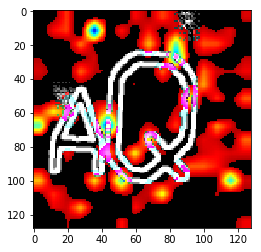

In [302]:
print(my_letters[np.argmax(y_train[lind])])
plt.imshow(cam)

'3L'